In [1]:
%%capture
! pip install pytorch_lightning
! pip install ogb
! pip install torch_geometric
! pip install torcheval
! pip install scienceplots

In [2]:
import torch
import pytorch_lightning as L
import torch_geometric as tg
from torch_geometric import transforms as T
from torch_geometric.utils import negative_sampling
from torch_geometric import nn
from torch.utils.data import DataLoader, Dataset
from torcheval import metrics
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scienceplots

from ogb.linkproppred import PygLinkPropPredDataset

In [3]:
dataset = PygLinkPropPredDataset(
    name="ogbl-ddi",
    root="./datasets",
    transform=T.ToSparseTensor(),
)

In [4]:
data = dataset[0]
split_edge = dataset.get_edge_split()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\utils\sparse.py:268: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  adj = torch.sparse_csr_tensor(


In [5]:
class DDIDataset(Dataset):
    def __init__(self, edges: torch.Tensor, edge_index: torch.Tensor, num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes
        self._edge_index = edge_index

    def __len__(self):
        return self.edges.shape[0]
    
    @property
    def edge_index(self):
        return self._edge_index

    def __getitem__(self, index: int):
        # get positive edges
        pos_edges = self.edges[index].t().view(-1, 1)
        # create negative edges
        neg_edges = negative_sampling(
            pos_edges,
            self.num_nodes,
            1,
            method="dense",
        )

        # class 1 for the positive edge, class 0 for the negative edges
        pos_label = torch.ones((pos_edges.shape[1],))
        neg_label = torch.zeros((neg_edges.shape[1],))

        edges_set = torch.cat([pos_edges, neg_edges], dim=1)
        edges_label = torch.cat([pos_label, neg_label], dim=0)
        return edges_set, edges_label

In [6]:
train_dataset = DDIDataset(split_edge["train"]["edge"], dataset.edge_index, data.num_nodes)
val_dataset = DDIDataset(split_edge["valid"]["edge"], dataset.edge_index, data.num_nodes)
test_dataset = DDIDataset(split_edge["test"]["edge"], dataset.edge_index, data.num_nodes)
batch_size = 4096

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
)

In [7]:
print(f"{len(train_dataset):,}")
print(f"{len(val_dataset):,}")
print(f"{len(test_dataset):,}")

1,067,911
133,489
133,489


In [8]:
class DDISage(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        aggr: str,
        normalization: bool,
    ):
        super(DDISage, self).__init__()
        assert num_layers > 0, "The number of layers must be greater than zero"
        self.sage = torch.nn.ModuleList()
        for i in range(num_layers):
            self.sage.append(
                nn.SAGEConv(
                    in_channels if i == 0 else hidden_channels,
                    hidden_channels,
                    aggr=aggr,
                    normalize=normalization,
                )
            )
        self.act = torch.nn.ReLU()

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        edge_mask: torch.Tensor,
    ):
        h = x
        for layer in self.sage:
            h = self.act(layer(h, edge_index))

        out = (h[edge_mask[0]] * h[edge_mask[1]]).sum(-1)
        return out.sigmoid()

In [9]:
class DDIModel(L.LightningModule):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        aggr: str,
        normalization: bool,
        lr: float,
        edge_index: torch.Tensor,
    ):
        super().__init__()
        self.model = DDISage(
            in_channels,
            hidden_channels,
            num_layers,
            aggr,
            normalization,
        )
        self.criterion = torch.nn.BCELoss()
        self.lr = lr
        self.edge_index = edge_index
        self.X = torch.ones((data.num_nodes, 1))
        self.history = {
            "epochs": [],
            "loss": [],
            "val_loss": [],
            "acc": [],
            "val_acc": [],
        }

        self.training_step_outputs = {
            "loss": [],
            "val_loss": [],
            "acc": [],
            "val_acc": [],
        }
        self.save_hyperparameters()

    def _shared_eval_step(self, data: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        accuracy = metrics.BinaryAccuracy()
        link, label = data
        link = link.to(self.device)
        label = label.to(self.device)
        self.X = self.X.to(self.device)
        self.edge_index = self.edge_index.to(self.device)
        
        link = link.reshape(-1, 2).permute(1, 0)
        label = label.flatten()

        pred = self.model(self.X, self.edge_index, link)
        loss = self.criterion(pred, label)
        accuracy.update(pred, label)
        return loss, accuracy.compute()

    def training_step(self, data: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        loss, accuracy = self._shared_eval_step(data)
        self.training_step_outputs["loss"].append(loss.item())
        self.training_step_outputs["acc"].append(accuracy)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", loss, prog_bar=True)
        return loss
    
    def validation_step(self, data: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        loss, accuracy = self._shared_eval_step(data)
        self.training_step_outputs["val_loss"].append(loss.item())
        self.training_step_outputs["val_acc"].append(accuracy)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", loss, prog_bar=True)
        return loss
    
    def test_step(self, data: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        loss, accuracy = self._shared_eval_step(data)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", loss, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self) -> None:
        self.history["epochs"].append(self.current_epoch)
        for key, item in self.training_step_outputs.items():
            self.history[key].append(sum(item) / len(item))

        self.training_step_outputs = {
            "loss": [],
            "val_loss": [],
            "acc": [],
            "val_acc": [],
        }

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [10]:
timer = L.callbacks.Timer()
early_stopping = L.callbacks.EarlyStopping(patience=10, monitor="val_loss", mode="min")
progress_bar = L.callbacks.TQDMProgressBar(refresh_rate=1)
callbacks = [timer, early_stopping, progress_bar]

In [12]:
trainer = L.Trainer(
    accelerator="gpu",
    num_sanity_val_steps=0,
    max_epochs=300,
    val_check_interval=1,
)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [13]:
model = DDIModel(
    in_channels=1,
    hidden_channels=64,
    num_layers=2,
    aggr="add",
    normalization=True,
    lr=1e-3,
    edge_index=dataset.edge_index,
)

In [14]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | DDISage | 8.4 K 
1 | criterion | BCELoss | 0     
--------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.034     Total estimated model params size (MB)


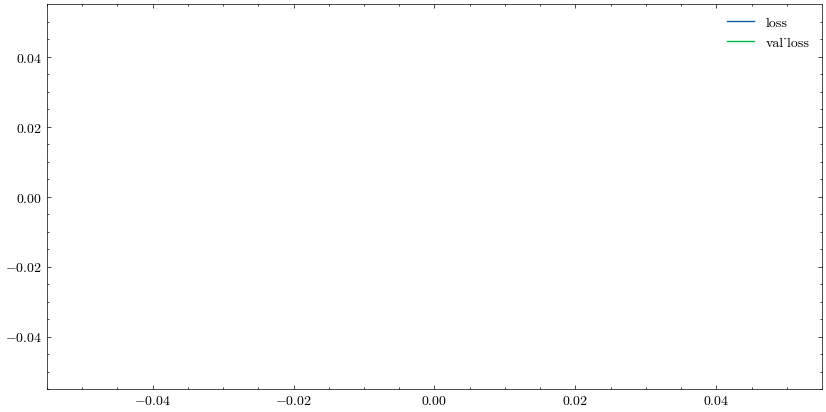

In [ ]:
plt.style.use(["science", "no-latex"])
plt.figure(figsize=(10, 5))

plt.plot(range(model.current_epoch), model.history["loss"])
plt.plot(range(model.current_epoch), model.history["val_loss"])
plt.legend(["loss", "val_loss"])

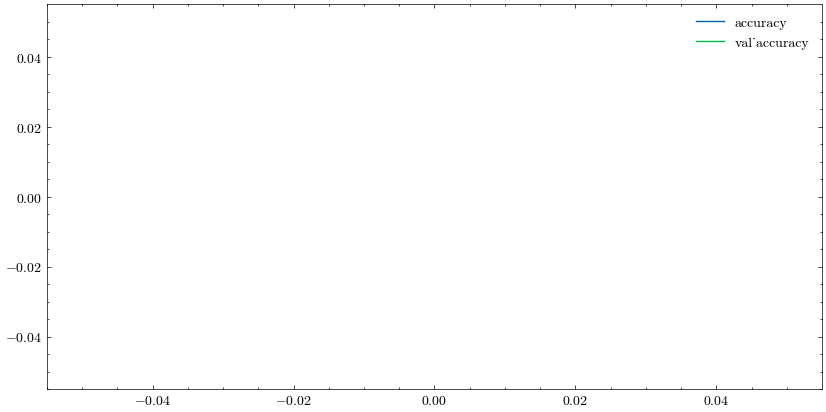

In [ ]:
plt.style.use(["science", "no-latex"])
plt.figure(figsize=(10, 5))

plt.plot(range(model.current_epoch), model.history["acc"])
plt.plot(range(model.current_epoch), model.history["val_acc"])
plt.legend(["accuracy", "val_accuracy"])

In [ ]:
paths = sorted(Path("/kaggle/working/lightning_logs").iterdir(), key=os.path.getmtime, reverse=True)

ckpt_path = os.path.join(paths[0], "checkpoints")
ckpt_file = os.listdir(ckpt_path)[0]
ckpt_full_path = os.path.join(ckpt_path, ckpt_file)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/lightning_logs/version_0/checkpoints'

In [ ]:
model = DDIModel.load_from_checkpoint(ckpt_full_path)

In [ ]:
trainer.test(model, test_loader)

In [ ]:
print(f"Train time: {timer.time_elapsed('train'):.3f}s")
print(f"Validate time: {timer.time_elapsed('validate'):.3f}s")
print(f"Test time: {timer.time_elapsed('test'):.3f}s")